https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data

## Initialization

In [1]:
import json
import os
import pickle
import shutil
from enum import Enum

import kagglehub
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from kagglehub.config import set_kaggle_credentials
from scipy.stats import ks_2samp
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split

credentials = json.load(
    open("credentials.json")
)  # Format {"username":"...", "api_key":"..."}
set_kaggle_credentials(**credentials)

Kaggle credentials set.


In [2]:
class SII(Enum):
    SII_NONE = 0
    SII_MILD = 1
    SII_MODERATE = 2
    SII_SEVERE = 3
    SII_UNKNOWN = 4


class Gender(Enum):
    MALE = 0
    FEMALE = 1


class FeatureGroup(Enum):
    DEMOGRAPHIC = "DEMOGRAPHIC"  # Information about age and sex of participants.
    INTERNET_USAGE = (
        "INTERNET_USAGE"  # Number of hours of using computer/internet per day.
    )
    ASSESSMENT_SCALE = "ASSESSMENT_SCALE"  # Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.
    PHYSICAL_MEASURES = "PHYSICAL_MEASURES"  # Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.
    FITNESSGRAM_VITALS = "FITNESSGRAM_VITALS"  # Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.
    FITNESSGRAM_CHILD = "FITNESSGRAM_CHILD"  #  Health related physical fitness assessment measuring five different parameters including aerobic capacity, muscular strength, muscular endurance, flexibility, and body composition.
    IMPEDANCE = "IMPEDANCE"  # Measure of key body composition elements, including BMI, fat, muscle, and water content.
    PHYSICAL_ACTIVITY_QA_CHILD = "PHYSICAL_ACTIVITY_QA_CHILD"  # Information about children's participation in vigorous activities over the last 7 days.
    PHYSICAL_ACTIVITY_QA_ADOLECENT = "PHYSICAL_ACTIVITY_QA_ADOLECENT"  # Information about children's participation in vigorous activities over the last 7 days.
    SLEEP_DISTURBANCE = (
        "SLEEP_DISTURBANCE"  # Scale to categorize sleep disorders in children.
    )
    INTERNET_ADDICTION_TEST = "INTERNET_ADDICTION_TEST"  # 20-item scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency.

In [3]:
DATASET_PATH = "data/problematic-internet-use/"
ID_COL = "id"
LABEL_COL = "sii"
GROUP_NAME_TO_FEATURE_GROUP = {
    "Demographics": FeatureGroup.DEMOGRAPHIC,
    "Children's Global Assessment Scale": FeatureGroup.ASSESSMENT_SCALE,
    "Physical Measures": FeatureGroup.PHYSICAL_MEASURES,
    "FitnessGram Vitals and Treadmill": FeatureGroup.FITNESSGRAM_VITALS,
    "FitnessGram Child": FeatureGroup.FITNESSGRAM_CHILD,
    "Bio-electric Impedance Analysis": FeatureGroup.IMPEDANCE,
    "Physical Activity Questionnaire (Adolescents)": FeatureGroup.PHYSICAL_ACTIVITY_QA_ADOLECENT,
    "Physical Activity Questionnaire (Children)": FeatureGroup.PHYSICAL_ACTIVITY_QA_CHILD,
    "Parent-Child Internet Addiction Test": FeatureGroup.INTERNET_ADDICTION_TEST,
    "Sleep Disturbance Scale": FeatureGroup.SLEEP_DISTURBANCE,
    "Internet Use": FeatureGroup.INTERNET_USAGE,
}

## Data Download

In [4]:
os.makedirs("data", exist_ok=True)
if not os.path.exists(DATASET_PATH):
    path = kagglehub.competition_download("child-mind-institute-problematic-internet-use")
    shutil.move(path, DATASET_PATH)

In [5]:
data_dictionary = pd.read_csv(f"{DATASET_PATH}data_dictionary.csv")
data_dictionary

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [6]:
FEATURE_GROUP_TO_COLUMNS = {
    v: data_dictionary.loc[data_dictionary["Instrument"] == k]["Field"].to_list()
    for k, v in GROUP_NAME_TO_FEATURE_GROUP.items()
}

In [7]:
# Numerical Features
NUMERICAL_FEATURES = (
    data_dictionary["Field"]
    .loc[
        data_dictionary["Type"].isin(["int", "float"])
        & ~data_dictionary["Field"].isin(
            FEATURE_GROUP_TO_COLUMNS[FeatureGroup.INTERNET_ADDICTION_TEST]
        )
    ]
    .to_list()
)
# Categorical Features
CATEGORICAL_FEATURES = (
    data_dictionary["Field"]
    .loc[
        data_dictionary["Type"].isin(["str", "categorical int"])
        & (data_dictionary["Field"] != ID_COL)
        & ~data_dictionary["Field"].isin(
            FEATURE_GROUP_TO_COLUMNS[FeatureGroup.INTERNET_ADDICTION_TEST]
        )
    ]
    .to_list()
)

In [8]:
def get_cols_from_df(df: pd.DataFrame, features) -> pd.DataFrame:
    return df[[ID_COL] + features + [LABEL_COL]].copy(deep=True)


def pre_processing(df: pd.DataFrame) -> pd.DataFrame:
    df["Basic_Demos-Sex"] = df["Basic_Demos-Sex"].apply(lambda x: Gender(x).name)
    df[LABEL_COL] = df[LABEL_COL].fillna(SII.SII_UNKNOWN.value).astype(int)
    for col in df.columns:
        if col in CATEGORICAL_FEATURES:
            df[col] = df[col].astype("category")
    return df


def load_user_events_df(user_id: str, is_train: bool = True) -> pd.DataFrame:
    mode = "train" if is_train else "test"
    path = f"{DATASET_PATH}series_{mode}.parquet/id={user_id}"
    events_df = pd.DataFrame()
    if not os.path.exists(path):
        return events_df

    files = os.listdir(path)
    for file in files:
        if file.endswith(".parquet"):
            events_df = pd.concat([events_df, pd.read_parquet(f"{path}/{file}")])
    return events_df


def save_image(experiment_name: str, filename: str) -> None:
    os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
    plt.savefig(f"experiments/{experiment_name}/{filename}.png")


def save_text(experiment_name: str, filename: str, text: str) -> None:
    with open(f"experiments/{experiment_name}/{filename}.txt", "w") as f:
        f.write(text)


def save_model(model, experiment_name: str):
    os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
    with open(f"experiments/{experiment_name}/model.pkl", "wb") as f:
        pickle.dump(model, f)


def save_model_metadata(experiment_name: str, **kwargs):
    with open(f"experiments/{experiment_name}/metadata.json", "w") as f:
        json.dump(kwargs, f, indent=4)


def get_feature_description(feature: str) -> str:
    row = data_dictionary.loc[data_dictionary["Field"] == feature].iloc[0]
    return f"[{row["Instrument"]}] {row["Description"]}"

In [9]:
data_dictionary.loc[
    data_dictionary["Field"].isin(CATEGORICAL_FEATURES)
    & (data_dictionary["Value Labels"] != "")
][["Field", "Value Labels"]].groupby("Value Labels").agg(list)

,Field
Value Labels,
"0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day",[PreInt_EduHx-computerinternet_hoursday]
"0=Male, 1=Female",[Basic_Demos-Sex]
"0=Needs Improvement, 1=Healthy Fitness Zone","[FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, FGC-FGC_SRL..."
"1=Small, 2=Medium, 3=Large",[BIA-BIA_Frame_num]
"1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=Exceptional",[BIA-BIA_Activity_Level_num]
"1=Weak, 2=Normal, 3=Strong","[FGC-FGC_GSND_Zone, FGC-FGC_GSD_Zone]"


> Data Questions
* How to handle missing labels
* How to model Season
* How to model User Events
> Modeling Hypotesis
* Multi Class Classification
* Binary Classification, spliting in bands
* Regression using `PCIAT-PCIAT_Total`
> TODO
* Evaluation 

## EDA

### Features Data

In [10]:
df_train = pd.read_csv(f"{DATASET_PATH}train.csv")
df_train = pre_processing(df_train)
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,MALE,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2
1,000fd460,Summer,9,MALE,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0
2,00105258,Summer,10,FEMALE,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0
3,00115b9f,Winter,9,MALE,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1
4,0016bb22,Spring,18,FEMALE,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,MALE,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1
3956,ffa9794a,Winter,10,MALE,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,4
3957,ffcd4dbd,Fall,11,MALE,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1
3958,ffed1dd5,Spring,13,MALE,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0


In [11]:
df_train.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,...,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,sii
count,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,...,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3960.000000
mean,10.433586,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,...,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.637374
std,3.574648,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,...,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.705471
min,5.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000
25%,8.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000
50%,10.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000
75%,13.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,6.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,4.000000
max,22.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,28.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,4.000000


In [12]:
df_train["sii"].value_counts(dropna=False)

sii
0    1594
4    1224
1     730
2     378
3      34
Name: count, dtype: int64

### Events Data

In [13]:
temporal_ids = [x.split("=")[-1] for x in os.listdir(f"{DATASET_PATH}series_train.parquet/")]
len(temporal_ids)

996

In [14]:
df_train["has_temporal_data"] = df_train["id"].apply(lambda x: x in temporal_ids)
# TODO: add it as numerical feature

In [15]:
df_train[["sii", "has_temporal_data"]].value_counts(dropna=False)

sii  has_temporal_data
4    False                1224
0    False                1011
     True                  583
1    False                 464
     True                  266
2    False                 241
     True                  137
3    False                  24
     True                   10
Name: count, dtype: int64

In [16]:
df_events = load_user_events_df(temporal_ids[0])
df_events

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.770546,0.115814,0.270649,0.143888,14.886057,0.0,8.333333,4187.000000,46920000000000,4,4,0.0
1,1,1.037095,0.057415,0.035650,0.152761,4.105440,0.0,14.666667,4186.166504,46925000000000,4,4,0.0
2,2,1.015306,0.076105,0.027556,0.099123,1.744674,0.0,21.000000,4185.333496,46930000000000,4,4,0.0
3,3,0.751853,0.120410,0.162099,0.092567,10.396823,0.0,18.000000,4184.500000,46935000000000,4,4,0.0
4,4,-0.137656,0.721863,0.666483,0.000379,42.136150,0.0,37.400002,4183.666504,46940000000000,4,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387559,387559,-0.865236,0.082798,-0.482923,0.000053,-29.023504,0.0,6.000000,3098.833252,83915000000000,5,4,22.0
387560,387560,-0.897907,0.001859,-0.295331,0.009981,-18.050568,0.0,6.000000,3098.666748,83920000000000,5,4,22.0
387561,387561,-0.555017,0.488289,-0.143589,0.444994,-11.356619,0.0,6.000000,3098.500000,83925000000000,5,4,22.0
387562,387562,-0.275457,0.461696,-0.800493,0.064299,-54.998112,0.0,6.000000,3098.333252,83930000000000,5,4,22.0


## Train

In [31]:
os.makedirs("experiments", exist_ok=True)

experiment_name = "second"
features = FEATURE_GROUP_TO_COLUMNS[FeatureGroup.IMPEDANCE]

TEST_SIZE = 0.2
RANDOM_STATE = 42
assert experiment_name
assert not os.path.exists(f"experiments/{experiment_name}"), "Experiment already exists"
assert features

In [32]:
df = get_cols_from_df(df_train, features)
train, test = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)
X_train = train.drop(columns=[ID_COL, LABEL_COL])
y_train = train[LABEL_COL]
X_test = test.drop(columns=[ID_COL, LABEL_COL])
y_test = test[LABEL_COL]

In [33]:
X_train.shape

(3168, 17)

In [34]:
parameters = {
    "objective": "multiclass",
    "num_class": 5, # TODO: fix
    "metric": "multi_logloss",
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 16,
    # "feature_fraction": 0.8,
    # "bagging_fraction": 0.8,
    # "bagging_freq": 5,
    "boosting_type": "gbdt",
    "verbosity": 3,
}

In [35]:
model = lgb.LGBMClassifier(**parameters)

In [36]:
model.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], categorical_feature=[x for x in X_train.columns if x in CATEGORICAL_FEATURES])

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.024194
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000189 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3585
[LightGBM] [Info] Number of data points in the train set: 3168, number of used features: 17
[LightGBM] [Info] Start training from score -0.903899
[LightGBM] [Info] Start training from score -1.694385
[LightGBM] [Info] Start training from score -2.350429
[LightGBM] [Info] Start training from score -4.802759
[LightGBM] [Info] Start training from score -1.178418
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(learning_rate=0.01, max_depth=6, metric='multi_logloss',
               num_class=5, num_leaves=16, objective='multiclass', verbosity=3)

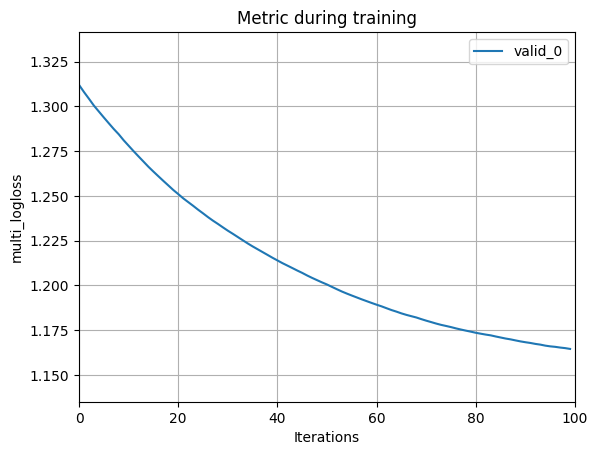

In [37]:
lgb.plot_metric(model)
save_image(experiment_name, "training_metrics")

## Evaluation

In [38]:
save_model(model, experiment_name)
save_model_metadata(
    experiment_name,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    parameters=parameters,
    model_type=model.__class__.__name__,
    features=features,
)

In [39]:
train_predictions = model.predict_proba(X_train)
train_predictions_labels = [np.argmax(x) for x in train_predictions]
save_text(experiment_name, "train_predictions", str(train_predictions.tolist()))

test_predictions = model.predict_proba(X_test)
test_predictions_labels = [np.argmax(x) for x in test_predictions]
save_text(experiment_name, "train_predictions", str(test_predictions.tolist()))

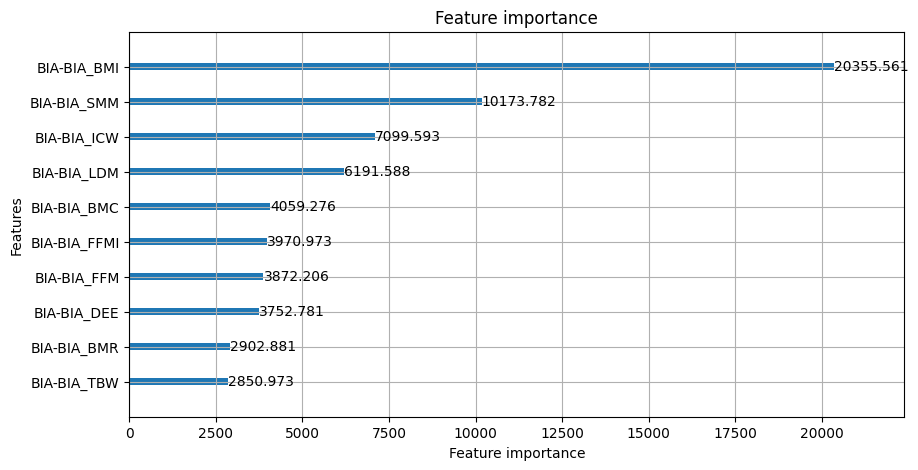

In [40]:
lgb.plot_importance(model, importance_type="gain", max_num_features=10, figsize=(10, 5))
save_image(experiment_name, "gain_feature_importance")

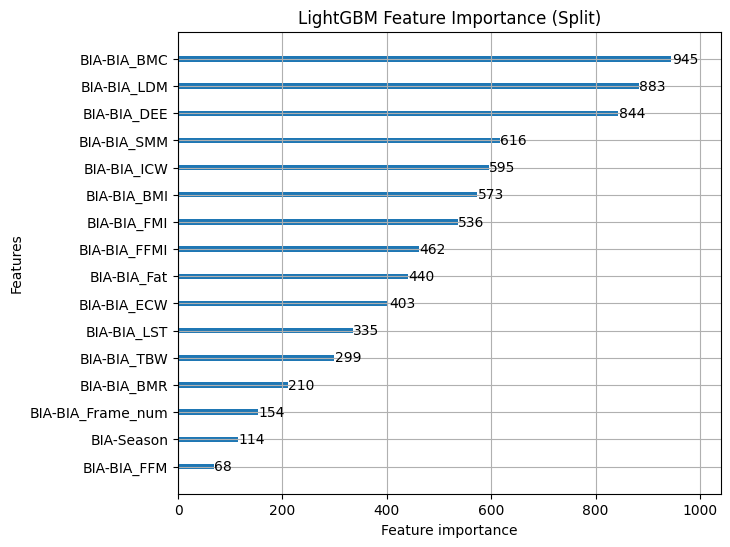

In [41]:
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
save_image(experiment_name, "split_feature_importance")

In [42]:
#TODO: improve code
train_auc_score = roc_auc_score(y_train, train_predictions, multi_class="ovr")
train_accuracy = accuracy_score(y_train, train_predictions_labels)
test_auc_score = roc_auc_score(y_test, test_predictions, multi_class="ovr")
test_accuracy = accuracy_score(y_test, test_predictions_labels)
report = f"""Train
* AUC: {train_auc_score}
* Accuracy: {train_accuracy}

Test
* AUC: {test_auc_score}
* Accuracy: {test_accuracy}
"""
print(report)
save_text(experiment_name, "metrics", report)

Train
* AUC: 0.7923468761832797
* Accuracy: 0.5628156565656566

Test
* AUC: 0.7111953193989397
* Accuracy: 0.5416666666666666



In [43]:
get_feature_description("BIA-BIA_BMC")

'[Bio-electric Impedance Analysis] Bone Mineral Content'

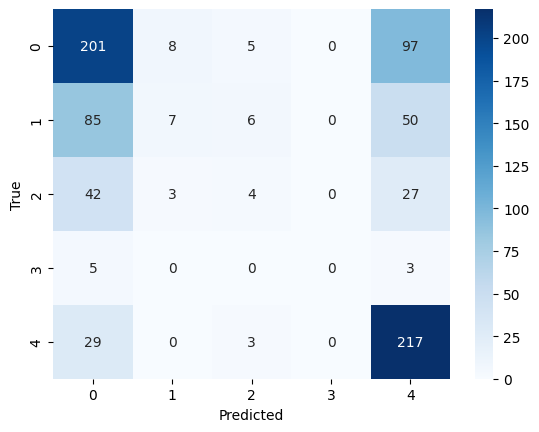

In [44]:
matrix = confusion_matrix(y_test, test_predictions_labels)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
save_image(experiment_name, "confusion_matrix")

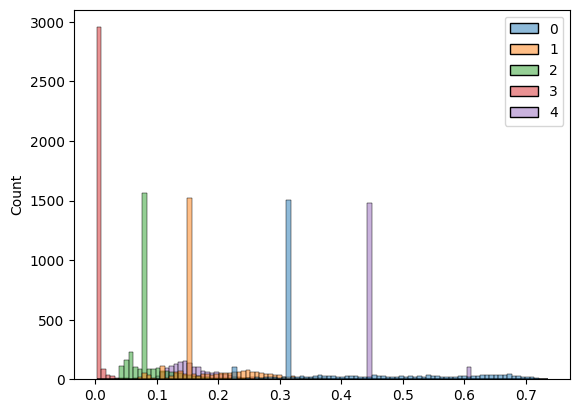

In [51]:
sns.histplot(train_predictions, bins=100)
save_image(experiment_name, "train_predictions_histogram")

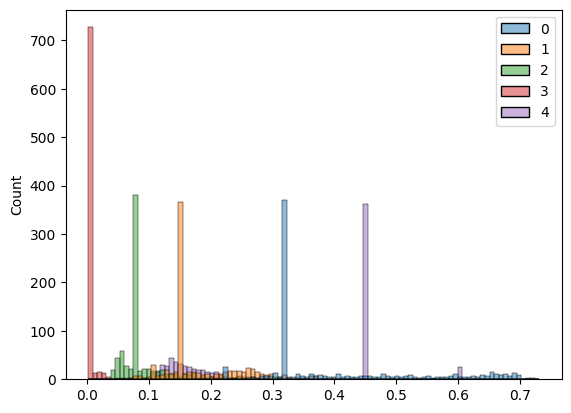

In [52]:
sns.histplot(test_predictions, bins=100)
save_image(experiment_name, "test_predictions_histogram")